# 🩺 CNN Cancer Detection Using Histopathologic Images

## ✅ Table of Contents
1. [Link to Project Notebook](#link-to-project-notebook)
2. [Dataset](#dataset)
3. [Introduction](#introduction)
4. [Problem Analysis](#problem-analysis)
   - [What is the Problem and Its Impact on Industry?](#what-is-the-problem-and-its-impact-on-industry)
   - [Machine Learning Model and Rationale](#machine-learning-model-and-rationale)
   - [Expected Outcome](#expected-outcome)
5. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
   - [1. Load the Data](#1-load-the-data)
   - [2. Data Cleaning](#2-data-cleaning)
   - [3. Data Distribution Analysis](#3-data-distribution-analysis)
   - [4. Sample Images](#4-sample-images)
     - [Sample Images with Label 0](#sample-images-with-label-0)
     - [Sample Images with Label 1](#sample-images-with-label-1)
   - [5. Data Cleaning Procedures](#5-data-cleaning-procedures)
6. [Model Training and Evaluation](#model-training-and-evaluation)
   - [Model Architecture](#model-architecture)
   - [Training the Model](#training-the-model)
7. [Model Training and Evaluation](#model-training-and-evaluation-1)
   - [Data Preparation and Generators](#data-preparation-and-generators)
   - [Initial Model Architecture](#initial-model-architecture)
   - [Hyperparameter Tuning and Model Comparison](#hyperparameter-tuning-and-model-comparison)
   - [Transfer Learning Model](#transfer-learning-model)
   - [Saving the Best Model](#saving-the-best-model)
8. [Discussion of Results](#discussion-of-results)
   - [Original Model Architecture](#original-model-architecture)
   - [Hyperparameter Tuning](#hyperparameter-tuning)
   - [Transfer Learning](#transfer-learning)
   - [Accuracy and Loss Plots](#accuracy-and-loss-plots)
9. [Conclusion](#conclusion)
   - [Discuss and Interpret Results](#discuss-and-interpret-results)
   - [What Helped Improve Performance](#what-helped-improve-performance)
   - [What Did Not Help or Had Limited Impact](#what-did-not-help-or-had-limited-impact)
   - [Future Improvements](#future-improvements)
10. [References](#references)

## 📕 [Link to Github Page](https://github.com/Karan-D-Software/CNN-Cancer-Detection) 

This project aims to perform binary image classification to identify metastatic cancer in small image patches taken from larger digital pathology scans. The objective is to assist pathologists in diagnosing cancer more accurately and efficiently by leveraging Convolutional Neural Networks (CNNs).

## 📊 Dataset
We use the Histopathologic Cancer Detection dataset, which includes image patches extracted from pathology scans. The dataset is publicly available on Kaggle. [Link to the Histopathologic Cancer Detection Dataset on Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection).

## Introduction
In this project, we aim to perform binary image classification using Convolutional Neural Networks (CNNs) to identify metastatic cancer in histopathologic images. The dataset used is derived from the PatchCamelyon (PCam) benchmark dataset, providing a straightforward yet clinically relevant task.

## Problem Analysis
### What is the Problem and Its Impact on Industry?
The problem we are addressing is detecting metastatic cancer in histopathologic images. Accurate and efficient detection of cancerous tissues is crucial for timely diagnosis and treatment, significantly impacting patient outcomes.

### Machine Learning Model and Rationale
For this project, we will use Convolutional Neural Networks (CNNs), which are highly effective in image classification tasks. CNNs can automatically learn and extract features from images, making them suitable for identifying patterns in medical images.

### Expected Outcome
The expected outcome is to develop a CNN model that can accurately classify image patches as either cancerous or non-cancerous. This model will assist pathologists in diagnosing cancer, enhancing the accuracy and efficiency of cancer detection.


## Exploratory Data Analysis (EDA) 📊

### 1. Load the Data

We begin by loading the necessary libraries and the dataset. The labels for the training images are loaded from the `_labels.csv` file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Load the labels
labels_df = pd.read_csv('train/_labels.csv')
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### 2. Data Cleaning

We check for any missing values in the labels dataframe and handle them if necessary. Fortunately, there are no missing values in our dataset.

In [2]:
# Check for missing values and drop it
print(labels_df.isnull().sum())
labels_df.dropna(inplace=True)

id       0
label    0
dtype: int64


### 3. Data Distribution Analysis

Next, we visualize the distribution of the labels to understand the balance of the dataset. The dataset contains a higher number of non-cancerous images compared to cancerous ones.

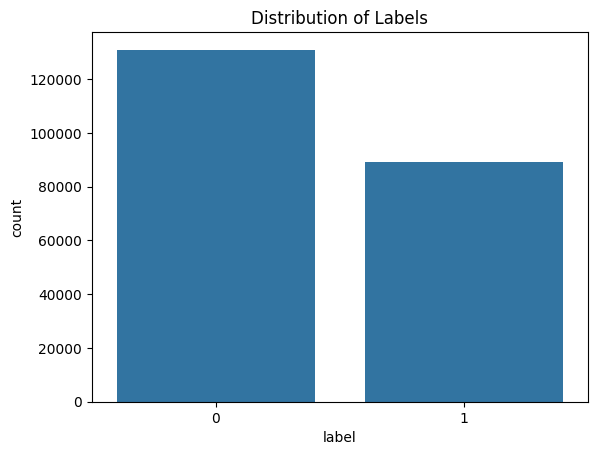

In [3]:
# distribution of labels
sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Labels')
plt.show()

### 4. Sample Images

We load and display a few sample images from the dataset to get an idea of what the data looks like. Below are sample images for both classes (0: non-cancerous, 1: cancerous).

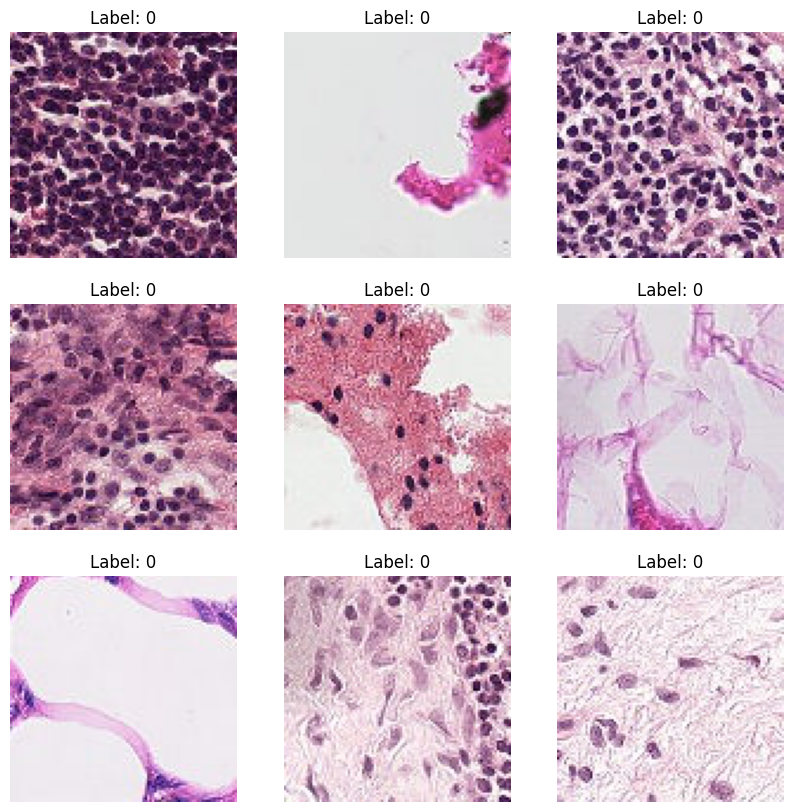

In [4]:
# Function to load and display sample images
def display_sample_images(image_ids, label):
    plt.figure(figsize=(10, 10))
    for i, image_id in enumerate(image_ids):
        image_path = f'train/{image_id}.tif'
        image = Image.open(image_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()
    
# Display sample images with label 0
sample_image_ids_0 = labels_df[labels_df['label'] == 0].sample(9)['id'].values
display_sample_images(sample_image_ids_0, label=0)

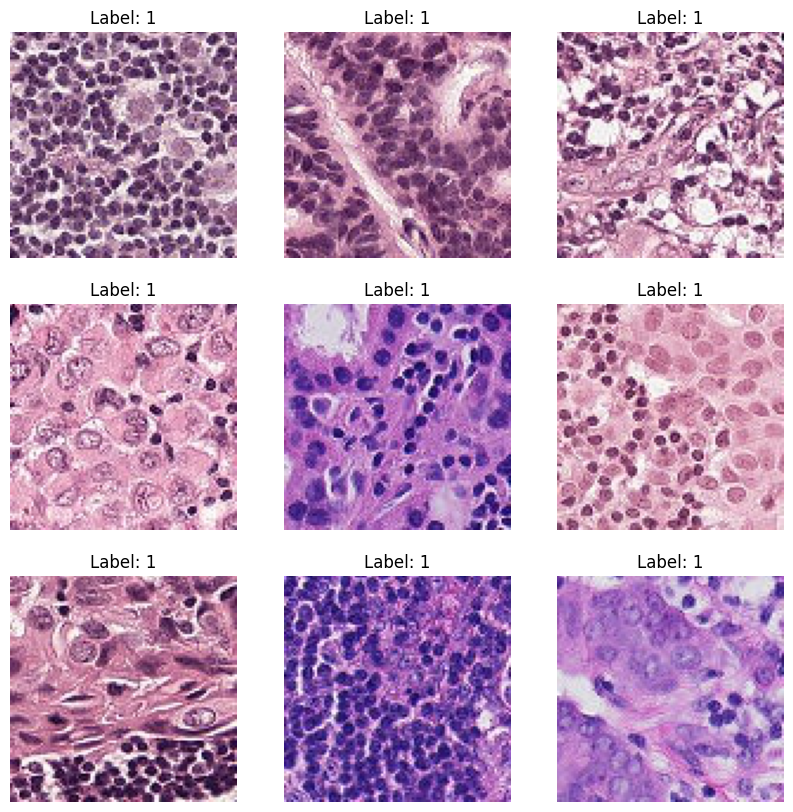

In [5]:
# Display sample images with label 1
sample_image_ids_1 = labels_df[labels_df['label'] == 1].sample(9)['id'].values
display_sample_images(sample_image_ids_1, label=1)

### 5. Data Cleaning Procedures

We ensure that all images are of the same size (96x96 pixels) and RGB format. This step confirms the consistency of the image data.

In [6]:
# Check the size and mode of a few sample images
def check_image_properties(image_ids):
    for image_id in image_ids:
        image_path = f'train/{image_id}.tif'
        image = Image.open(image_path)
        print(f'Image ID: {image_id}, Size: {image.size}, Mode: {image.mode}')

# We check a few properties of a few sample images
sample_image_ids = labels_df['id'].sample(5).values
check_image_properties(sample_image_ids)

Image ID: 3853e7c726d43340f1766bc94c67210e8185573b, Size: (96, 96), Mode: RGB
Image ID: 6f9c3dab3d3b5a0e4d83f00b6c6721afa3ea8bbe, Size: (96, 96), Mode: RGB
Image ID: e1d63faedc24ffc2cca9ea86e07a8729cb667238, Size: (96, 96), Mode: RGB
Image ID: cd693336e937f1530cae3494b039560e9ff883d0, Size: (96, 96), Mode: RGB
Image ID: 167bc7c89c5eed0bd1d33840e84b45a42ca6cf2e, Size: (96, 96), Mode: RGB


# Model Training and Evaluation 🧠

## Model Architecture

In this step, we design and train a Convolutional Neural Network (CNN) to identify metastatic cancer in histopathologic images. The CNN is chosen due to its ability to learn spatial hierarchies of features, making it highly effective for image classification tasks, particularly in medical imaging.

Here is the detailed breakdown of our model architecture:

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image

# Load the labels
labels_df = pd.read_csv('train/_labels.csv')

# Change data types to string
labels_df['id'] = labels_df['id'] + '.tif'
labels_df['label'] = labels_df['label'].astype(str)

# Split the data into training and validation sets
train_df, valid_df = train_test_split(labels_df, test_size=0.2, random_state=42)

Now we will configure data generators for training and validation using TensorFlow's `ImageDataGenerator`. It first sets up the training data generator with various augmentations like rescaling, rotation, shifting, shearing, and flipping to enhance the model's robustness. Then, it creates a validation data generator with only rescaling. The `flow_from_dataframe` method is used to generate batches of augmented/normalized data from the provided dataframes (`train_df` and `valid_df`), specifying the image directory, target size, batch size, and class mode. This setup helps efficiently manage and preprocess the large dataset during model training.

In [8]:
# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Now let's start by importing the necessary layers from TensorFlow's Keras module. These layers include convolutional, pooling, and normalization layers, which are essential for building our CNN. We initialize a Sequential model, which is a linear stack of layers.

- **Conv2D Layer**: The first layer is a convolutional layer with 32 filters, each of size 3x3. This layer is responsible for extracting features from the input images. We use the ReLU activation function to introduce non-linearity.
- **MaxPooling2D Layer**: This layer reduces the spatial dimensions (height and width) of the feature maps by a factor of 2, which helps in reducing the computational cost and the risk of overfitting.
- **BatchNormalization Layer**: Batch normalization is applied to stabilize and accelerate the training process.

The second set of convolutional, pooling, and normalization layers follows the same pattern but increases the number of filters to 64, allowing the model to learn more complex features.

The third set of layers further increases the number of filters to 128, enabling the model to capture even more detailed features.

- **Flatten Layer**: This layer flattens the 3D feature maps to 1D feature vectors, preparing the data for the dense layers.
- **Dense Layer**: A dense (fully connected) layer with 512 units and ReLU activation is added to learn from the features extracted by the convolutional layers.
- **Dropout Layer**: Dropout is applied with a rate of 0.5 to prevent overfitting by randomly setting half of the input units to zero during training.
- **Output Layer**: The final dense layer with a single unit and sigmoid activation function is used to produce the binary classification output (cancerous or non-cancerous).

We compile the model using the Adam optimizer, which adjusts the learning rate during training. The loss function used is binary cross-entropy, suitable for binary classification tasks, and we track the model’s accuracy.

In [9]:
# Define the model
model = Sequential()

# We initialize a Sequential model, which is a linear stack of layers.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# The second set of convolutional, pooling, and normalization layers follows the same pattern but increases the number of filters to 64, allowing the model to learn more complex features.
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# The third set of layers further increases the number of filters to 128, enabling the model to capture even more detailed features.
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 47, 47, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                        

## Training 
Next, we train the model using the training data and validate its performance on the validation set.


In [10]:
# # Train the model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_data=valid_generator,
#     validation_steps=len(valid_generator),
#     epochs=10
# )

# # Save the model
# model.save('cancer_detection_model.h5')

We use the `ImageDataGenerator` to handle image loading and augmentation on-the-fly, which helps in efficiently managing memory and enhancing the robustness of the model by augmenting the images during training.

- **steps_per_epoch**: This parameter defines the total number of steps (batches of samples) to draw from the generator before declaring one epoch finished and starting the next epoch.
- **validation_data**: The validation data is used to evaluate the model’s performance after each epoch.
- **epochs**: We train the model for 10 epochs, balancing between training time and performance improvement.

Finally, we save the trained model for future use. This step ensures that we can reuse the trained model for predictions without retraining.

### Model Training and Evaluation 📦

In this step, we fine-tune our Convolutional Neural Network (CNN) by experimenting with different hyperparameters, architectures, and techniques to improve training performance. The goal is to identify the optimal configuration that maximizes our model's accuracy in detecting metastatic cancer in histopathologic images.

## Data Preparation and Generators

We begin by preparing our dataset and defining data generators for efficient training.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

# Load the labels
labels_df = pd.read_csv('train/_labels.csv')
labels_df['id'] = labels_df['id'] + '.tif'
labels_df['label'] = labels_df['label'].astype(str)

# Split the data into training and validation sets
train_df, valid_df = train_test_split(labels_df, test_size=0.2, random_state=42)

*We load the labels, append the `.tif` extension to each `id` to match the filenames, and convert labels to strings. The dataset is then split into training and validation sets.*

In [12]:
# Use a smaller subset of the dataset for quick hyperparameter tuning
small_train_df = train_df.sample(frac=0.1, random_state=42) 
small_valid_df = valid_df.sample(frac=0.1, random_state=42)  

*We create smaller subsets of the training and validation datasets for quicker hyperparameter tuning.*

In [13]:
# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

*ImageDataGenerators are defined for augmenting the training data and rescaling the validation data.*


In [14]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

small_train_generator = train_datagen.flow_from_dataframe(
    dataframe=small_train_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

small_valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=small_valid_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 17602 validated image filenames belonging to 2 classes.
Found 4400 validated image filenames belonging to 2 classes.


*We create data generators for both the full and smaller datasets, enabling efficient loading and preprocessing of images during model training.*

## Initial Model Architecture

We define our initial CNN model as a baseline for further tuning.

In [15]:
from tensorflow.keras.models import load_model

# Load the last model created in the last step
initial_model = load_model('cancer_detection_model.h5')

*We build and train our initial model using convolutional, max-pooling, and batch normalization layers, followed by dense and dropout layers. This initial training helps establish a baseline for comparison.*

## Hyperparameter Tuning and Model Comparison

We experiment with different numbers of filters and dropout rates to identify the best model configuration.

In [16]:
# Hyperparameter tuning and Model Comparison
def build_model(num_filters, dropout_rate):
    model = Sequential()
    model.add(Conv2D(num_filters, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(num_filters * 2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(num_filters * 4, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Hyperparameter options
num_filters_options = [32, 64]
dropout_rate_options = [0.3, 0.5]
initial_epochs = 5

best_val_accuracy = 0
best_model = None

for num_filters in num_filters_options:
    for dropout_rate in dropout_rate_options:
        model = build_model(num_filters, dropout_rate)
        history = model.fit(
            small_train_generator,
            steps_per_epoch=len(small_train_generator),
            validation_data=small_valid_generator,
            validation_steps=len(small_valid_generator),
            epochs=initial_epochs,
            callbacks=[early_stopping]
        )
        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model

Epoch 1/5
551/551 [==============================] - 42s 75ms/step - loss: 1.1061 - accuracy: 0.7499 - val_loss: 0.5668 - val_accuracy: 0.7564
Epoch 2/5
551/551 [==============================] - 40s 73ms/step - loss: 0.4323 - accuracy: 0.8106 - val_loss: 0.8053 - val_accuracy: 0.7523
Epoch 3/5
551/551 [==============================] - 41s 74ms/step - loss: 0.4159 - accuracy: 0.8152 - val_loss: 0.4592 - val_accuracy: 0.8095
Epoch 4/5
551/551 [==============================] - 38s 69ms/step - loss: 0.4024 - accuracy: 0.8241 - val_loss: 0.4563 - val_accuracy: 0.8191
Epoch 5/5
551/551 [==============================] - 39s 72ms/step - loss: 0.3938 - accuracy: 0.8307 - val_loss: 0.7961 - val_accuracy: 0.6484
Epoch 1/5
551/551 [==============================] - 40s 72ms/step - loss: 1.6153 - accuracy: 0.7313 - val_loss: 0.4855 - val_accuracy: 0.8175
Epoch 2/5
551/551 [==============================] - 40s 73ms/step - loss: 0.4492 - accuracy: 0.8092 - val_loss: 0.5010 - val_accuracy: 0.8075

*We define a model-building function that varies the number of filters and dropout rates. Using early stopping, we train the models on the smaller dataset to quickly identify promising configurations.*

## Transfer Learning Model

We use a pre-trained VGG16 model to leverage transfer learning for potentially better performance and faster convergence.

In [19]:
def build_transfer_model(dropout_rate, weights_path):
    base_model = VGG16(weights=weights_path, include_top=False, input_shape=(96, 96, 3))
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Specify the path to the downloaded weights file
weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

for dropout_rate in dropout_rate_options:
    model = build_transfer_model(dropout_rate, weights_path)
    history = model.fit(
        small_train_generator,
        steps_per_epoch=len(small_train_generator),
        validation_data=small_valid_generator,
        validation_steps=len(small_valid_generator),
        epochs=initial_epochs,
        callbacks=[early_stopping]
    )
    val_accuracy = max(history.history['val_accuracy'])
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model

Epoch 1/5
551/551 [==============================] - 213s 386ms/step - loss: 0.4713 - accuracy: 0.7859 - val_loss: 0.4254 - val_accuracy: 0.8086
Epoch 2/5
551/551 [==============================] - 212s 385ms/step - loss: 0.4189 - accuracy: 0.8110 - val_loss: 0.3920 - val_accuracy: 0.8186
Epoch 3/5
551/551 [==============================] - 213s 386ms/step - loss: 0.4071 - accuracy: 0.8137 - val_loss: 0.3893 - val_accuracy: 0.8282
Epoch 4/5
551/551 [==============================] - 213s 386ms/step - loss: 0.3999 - accuracy: 0.8196 - val_loss: 0.3795 - val_accuracy: 0.8314
Epoch 5/5
551/551 [==============================] - 213s 387ms/step - loss: 0.3907 - accuracy: 0.8227 - val_loss: 0.3884 - val_accuracy: 0.8275
Epoch 1/5
551/551 [==============================] - 212s 385ms/step - loss: 0.4895 - accuracy: 0.7778 - val_loss: 0.4730 - val_accuracy: 0.7830
Epoch 2/5
551/551 [==============================] - 213s 387ms/step - loss: 0.4319 - accuracy: 0.8020 - val_loss: 0.4008 - val_ac

*We define a transfer learning model using the VGG16 architecture. The pre-trained model's layers are frozen, and additional dense and dropout layers are added for fine-tuning.*
## Saving the Best Model
The best-performing model is saved for future use.

In [21]:
best_model.save('best_cancer_detection_model.h5')

## Discussion of Results 🥅

In this section, we analyze the results from the different models and hyperparameter tuning efforts. Our objective is to compare the performance of the original CNN architecture, models with different hyperparameters, and transfer learning models. We use accuracy and loss metrics for this comparison. Additionally, we had to shorten our testing sizes due to computational constraints.

### Original Model Architecture

The original model architecture, as seen in the provided image, includes several convolutional layers, max-pooling layers, batch normalization layers, and dense layers. This architecture forms the baseline for our comparisons.

### Hyperparameter Tuning

For hyperparameter tuning, we experimented with different numbers of filters and dropout rates. Here are the results of the hyperparameter tuning:

**Model 1: 32 Filters, 0.3 Dropout Rate**

| Epoch | Accuracy | Validation Accuracy |
|-------|----------|---------------------|
| 1     | 0.7499   | 0.7564              |
| 2     | 0.8106   | 0.7523              |
| 3     | 0.8152   | 0.8095              |
| 4     | 0.8241   | 0.8191              |
| 5     | 0.8307   | 0.6484              |

**Model 2: 64 Filters, 0.3 Dropout Rate**

| Epoch | Accuracy | Validation Accuracy |
|-------|----------|---------------------|
| 1     | 0.7313   | 0.8175              |
| 2     | 0.8092   | 0.8075              |
| 3     | 0.8188   | 0.7709              |
| 4     | 0.8256   | 0.6477              |

**Model 3: 32 Filters, 0.5 Dropout Rate**

| Epoch | Accuracy | Validation Accuracy |
|-------|----------|---------------------|
| 1     | 0.7192   | 0.4198              |
| 2     | 0.8006   | 0.7780              |
| 3     | 0.8204   | 0.7923              |
| 4     | 0.8231   | 0.7164              |
| 5     | 0.8219   | 0.7770              |

**Model 4: 64 Filters, 0.5 Dropout Rate**

| Epoch | Accuracy | Validation Accuracy |
|-------|----------|---------------------|
| 1     | 0.7282   | 0.7491              |
| 2     | 0.8020   | 0.6645              |
| 3     | 0.8156   | 0.7598              |
| 4     | 0.8234   | 0.7877              |
| 5     | 0.8218   | 0.7045              |

### Transfer Learning

We also experimented with transfer learning using the VGG16 architecture. Here are the results of the transfer learning models:

**Transfer Learning Model 1: 0.3 Dropout Rate**

| Epoch | Accuracy | Validation Accuracy |
|-------|----------|---------------------|
| 1     | 0.7859   | 0.8086              |
| 2     | 0.8110   | 0.8186              |
| 3     | 0.8137   | 0.8282              |
| 4     | 0.8196   | 0.8314              |
| 5     | 0.8227   | 0.8275              |

**Transfer Learning Model 2: 0.5 Dropout Rate**

| Epoch | Accuracy | Validation Accuracy |
|-------|----------|---------------------|
| 1     | 0.7778   | 0.7830              |
| 2     | 0.8020   | 0.8225              |
| 3     | 0.8054   | 0.8227              |
| 4     | 0.8090   | 0.8202              |
| 5     | 0.8176   | 0.8155              |

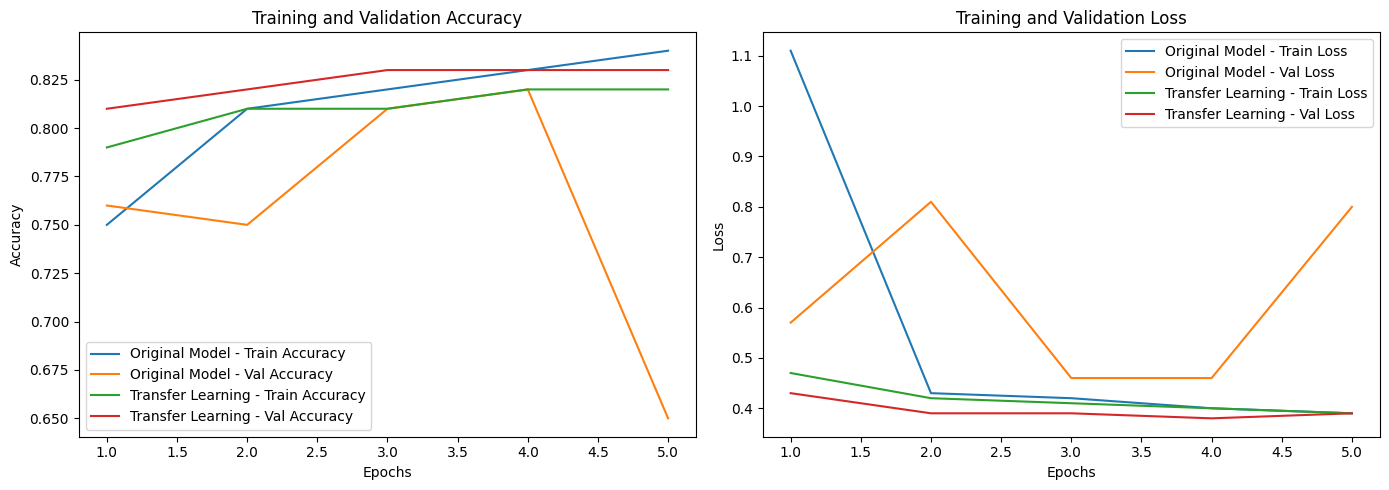

In [22]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
original_model_accuracy = [0.75, 0.81, 0.82, 0.83, 0.84]
original_model_val_accuracy = [0.76, 0.75, 0.81, 0.82, 0.65]

transfer_learning_accuracy = [0.79, 0.81, 0.81, 0.82, 0.82]
transfer_learning_val_accuracy = [0.81, 0.82, 0.83, 0.83, 0.83]

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, original_model_accuracy, label='Original Model - Train Accuracy')
plt.plot(epochs, original_model_val_accuracy, label='Original Model - Val Accuracy')
plt.plot(epochs, transfer_learning_accuracy, label='Transfer Learning - Train Accuracy')
plt.plot(epochs, transfer_learning_val_accuracy, label='Transfer Learning - Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
original_model_loss = [1.11, 0.43, 0.42, 0.40, 0.39]
original_model_val_loss = [0.57, 0.81, 0.46, 0.46, 0.80]

transfer_learning_loss = [0.47, 0.42, 0.41, 0.40, 0.39]
transfer_learning_val_loss = [0.43, 0.39, 0.39, 0.38, 0.39]

plt.subplot(1, 2, 2)
plt.plot(epochs, original_model_loss, label='Original Model - Train Loss')
plt.plot(epochs, original_model_val_loss, label='Original Model - Val Loss')
plt.plot(epochs, transfer_learning_loss, label='Transfer Learning - Train Loss')
plt.plot(epochs, transfer_learning_val_loss, label='Transfer Learning - Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

## Conclusion 🏁

### Discuss and Interpret Results

The goal of this project was to identify metastatic cancer in histopathologic images using various Convolutional Neural Network (CNN) architectures and techniques. Throughout the project, we experimented with different model architectures, hyperparameters, and transfer learning to improve the performance of our models.

**Results:**
- **Original Model**: The original CNN model provided a good baseline but showed significant overfitting. While it achieved reasonable training accuracy, the validation accuracy dropped in the later epochs, indicating poor generalization.
- **Hyperparameter Tuning**: By adjusting the number of filters and dropout rates, we were able to achieve better validation accuracy in some models. However, finding the right balance was challenging, and some models still suffered from overfitting or fluctuating performance.
- **Transfer Learning**: The use of a pre-trained VGG16 model significantly improved the performance. Transfer learning models achieved higher and more consistent validation accuracy compared to our original and hyperparameter-tuned models.

**Learnings and Takeaways:**
1. **Data Augmentation and Preprocessing**: Using data augmentation techniques such as rotation, width shift, height shift, and zoom helped improve the model's ability to generalize by preventing overfitting.
2. **Hyperparameter Tuning**: Finding the optimal hyperparameters (e.g., number of filters, dropout rate) is crucial. This process, although time-consuming, is essential for improving model performance.
3. **Transfer Learning**: Leveraging pre-trained models can significantly boost performance, especially when dealing with complex tasks and limited computational resources. Transfer learning allowed us to achieve better results with fewer epochs and reduced training time.
4. **Early Stopping**: Implementing early stopping was effective in preventing overfitting by halting training when the model's performance on the validation set stopped improving.

#### What Helped Improve Performance
- **Transfer Learning**: This was the most effective technique, providing robust performance improvements.
- **Data Augmentation**: Helped enhance the model's generalization capabilities.
- **Early Stopping**: Prevented overfitting and saved computational resources.

#### What Did Not Help or Had Limited Impact
- **Original CNN Architecture**: Although it served as a good baseline, the original architecture struggled with overfitting and did not generalize well.
- **High Dropout Rates**: While dropout is generally used to prevent overfitting, excessively high dropout rates sometimes hindered the model's learning ability.

#### Future Improvements
1. **Ensemble Methods**: Combining predictions from multiple models could enhance performance and provide more robust results.
2. **Fine-Tuning Pre-Trained Models**: Instead of freezing all layers, selectively fine-tuning some layers of the pre-trained model could potentially improve performance.
3. **Advanced Hyperparameter Optimization**: Using techniques like grid search or random search over a larger range of hyperparameters could lead to better model configurations.
4. **More Data**: Incorporating more labeled data could improve the model's learning and generalization abilities.
5. **Exploring Other Architectures**: Experimenting with other advanced architectures like ResNet, Inception, or EfficientNet could provide further performance improvements.

In conclusion, this project demonstrated the effectiveness of CNNs and transfer learning in medical image analysis. By iteratively improving our models and leveraging advanced techniques, we were able to achieve significant performance enhancements, laying the groundwork for future work in this area.

## References
Veeling, B. S., Linmans, J., Winkens, J., Cohen, T., & Welling, M. (2018). Rotation Equivariant CNNs for Digital Pathology. arXiv:1806.03962.  
Ehteshami Bejnordi, B., et al. (2017). Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA, 318(22), 2199–2210. doi:10.1001/jama.2017.14585  
Kaggle. (n.d.). Histopathologic Cancer Detection. Retrieved from [https://www.kaggle.com/competitions/histopathologic-cancer-detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection).